# Neural SDE (VAE)

This implementation is based on the Pytorch version of Latent SDE from [`torchsde`](https://github.com/google-research/torchsde/blob/master/examples/latent_sde_lorenz.py) library. 
The model resembles [Variational Autoencoder (VAE) models](https://arxiv.org/abs/1312.6114) in a way that it tries to learn a latent space (more precisely in this case, the dynamic of latent variables) given data. 

The training follows a Bayesian inference procedure where we assume the prior of an SDE has a simple drift function (`prior_drift`).

The posterior is approximated by a neural SDE with a more complex drift function (`posterior_drift`). Note that both prior and posterior share the same diffusion.

The objective function is computed via evidence lower bound (ELBO) which requires getting Kullback-Leibler (KL) divergence between the prior and the approximated posterior.

The KL divergence turns out to be a result of Girsanov's theorem. The function `diffrax.misc.sde_kl_divergence` allows us to augment the original SDE with KL estimation.

This notebook for this example can be found [here](https://github.com/patrick-kidger/diffrax/blob/main/examples/neural_sde_vae.ipynb). See [this](https://docs.kidger.site/diffrax/examples/neural_sde_gan/) for an alternative way of training neural SDEs using GAN techniques.

**Reference**
```bibtex
@phdthesis{kidger2021on,
    title={{O}n {N}eural {D}ifferential {E}quations},
    author={Patrick Kidger},
    year={2021},
    school={University of Oxford},
}

@article{li2020scalable,
  title={Scalable gradients for stochastic differential equations},
  author={Li, Xuechen and Wong, Ting-Kam Leonard and Chen, Ricky T. Q. and Duvenaud, David},
  journal={International Conference on Artificial Intelligence and Statistics},
  year={2020}
}
```

In [1]:
from typing import List

import diffrax
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import optax

Generate Lorenz data (see Section 9.10.2 of [the paper](https://arxiv.org/pdf/2001.01328.pdf))

In [2]:
def generate_lorenz(
    t0=0.0,  # set start time
    t1=2.0,  # set end time
    batch_size=1024,  # number of trajectories
    a=(10.0, 28.0, 8.0 / 3),  # coefficient for drift function
    b=(0.15, 0.15, 0.15),  # coefficient for difussion funcion
    normalize=True,  # whether to normialize data
    noise_std=0.01,  # add noise to training data
    *,
    key,
):

    ts = jnp.linspace(t0, t1, num=100)

    # define drift function
    def drift(t, y, args):
        a1, a2, a3 = a
        x1, x2, x3 = y

        f1 = a1 * (x2 - x1)
        f2 = a2 * x1 - x2 - x1 * x3
        f3 = x1 * x2 - a3 * x3
        return jnp.concatenate([f1[None], f2[None], f3[None]])

    # define diffusion function
    def diffusion(t, y, args):
        b1, b2, b3 = b
        x1, x2, x3 = y

        g1 = x1 * b1
        g2 = x2 * b2
        g3 = x3 * b3
        return jnp.concatenate([g1[None], g2[None], g3[None]])

    # sample via SDE solver
    def integrate(y0, path_key):
        bm = diffrax.UnsafeBrownianPath(shape=(3,), key=path_key)
        lorenz_sde = diffrax.MultiTerm(
            diffrax.ODETerm(drift), diffrax.ControlTerm(diffusion, bm)
        )
        saveat = diffrax.SaveAt(ts=ts)
        solver = diffrax.Euler()
        sol = diffrax.diffeqsolve(
            lorenz_sde,
            solver,
            t0=t0,
            t1=t1,
            y0=y0,
            saveat=saveat,
            adjoint=diffrax.NoAdjoint(),
            dt0=1e-3,
        )
        return sol.ys

    y0_key, bm_key, noise_key = jrandom.split(key, 3)
    y0 = jrandom.normal(key=y0_key, shape=(batch_size, 3))
    path_key = jrandom.split(bm_key, batch_size)
    ys = jax.vmap(integrate)(y0, path_key)

    if normalize:
        mean_y = jnp.mean(ys, axis=(0, 1), keepdims=True)
        std_y = jnp.std(ys, axis=(0, 1), keepdims=True)
        ys = (ys - mean_y) / std_y + jrandom.normal(
            key=noise_key, shape=ys.shape
        ) * noise_std
    else:
        ys = ys + jrandom.normal(key=noise_key, shape=ys.shape) * noise_std

    return ts, ys

`Encoder` will transform the trajectories of data into a new representation using GRU

In [3]:
class Encoder(eqx.Module):

    gru: eqx.nn.GRUCell
    linear: eqx.nn.Linear

    def __init__(self, input_size, hidden_size, output_size, *, key) -> None:
        super().__init__()
        gru_key, linear_key = jrandom.split(key)
        self.gru = eqx.nn.GRUCell(
            input_size=input_size, hidden_size=hidden_size, key=gru_key
        )
        self.linear = eqx.nn.Linear(
            in_features=hidden_size, out_features=output_size, key=linear_key
        )

    def __call__(self, x):
        def scan_fn(state, input):
            new_state = self.gru(input, state)
            return new_state, new_state

        init_state = jnp.zeros(self.gru.hidden_size)
        _, out = jax.lax.scan(scan_fn, init_state, x)
        out = jax.vmap(self.linear)(out)
        return out

Define drift functions and a diffusion function of neural SDEs

In [4]:
class DriftPosterior(eqx.Module):

    net: eqx.nn.MLP

    def __init__(self, latent_size, context_size, hidden_size, *, key) -> None:

        self.net = eqx.nn.MLP(
            in_size=latent_size + context_size,
            width_size=hidden_size,
            out_size=latent_size,
            depth=2,
            activation=jax.nn.softplus,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.net(y)


class DriftPrior(eqx.Module):

    net: eqx.nn.MLP

    def __init__(self, latent_size, hidden_size, *, key):
        self.net = eqx.nn.MLP(
            in_size=latent_size,
            width_size=hidden_size,
            out_size=latent_size,
            depth=2,
            activation=jax.nn.softplus,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.net(y)


class Diffusion(eqx.Module):

    nets: List[eqx.nn.MLP]

    def __init__(self, latent_size, hidden_size, *, key):

        keys = jrandom.split(key, latent_size)
        self.nets = [
            eqx.nn.MLP(
                in_size=1,
                width_size=hidden_size,
                out_size=1,
                depth=1,
                activation=jax.nn.softplus,
                final_activation=jax.nn.sigmoid,
                key=i_key,
            )
            for i_key in keys
        ]

    def __call__(self, t, y, args):
        y = jnp.split(y, indices_or_sections=len(self.nets))
        out = [net_i(y_i) for net_i, y_i in zip(self.nets, y)]
        return jnp.concatenate(out, axis=0)

In [5]:
def normal_logprob(y, loc, scale):
    return -0.5 * ((y - loc) / scale) ** 2 - jnp.log(scale) - 0.5 * jnp.log(2 * jnp.pi)


def normal_kl_divergence(loc1, scale1, loc2, scale2):
    var_ratio = (scale1 / scale2) ** 2
    t1 = ((loc2 - loc1) / scale2) ** 2
    return 0.5 * (var_ratio + t1 - 1 - jnp.log(var_ratio))

Main model with methods solving (augmented) SDE and generating samples

In [6]:
class LatentSDE(eqx.Module):

    encoder: eqx.Module
    posterior_drift: eqx.Module
    prior_drift: eqx.Module
    diffusion: eqx.Module
    qz0_net: eqx.nn.Linear
    projector: eqx.nn.Linear
    pz0_mean: jnp.ndarray
    pz0_logstd: jnp.ndarray
    t0: float
    t1: float
    latent_size: int

    def __init__(
        self, data_size, latent_size, context_size, hidden_size, t0, t1, *, key
    ) -> None:
        super().__init__()
        self.t0, self.t1 = t0, t1
        self.latent_size = latent_size
        keys = jrandom.split(key, num=6)
        self.encoder = Encoder(
            input_size=data_size,
            hidden_size=hidden_size,
            output_size=context_size,
            key=keys[0],
        )
        self.qz0_net = eqx.nn.Linear(
            context_size, latent_size + latent_size, key=keys[1]
        )

        self.posterior_drift = DriftPosterior(
            latent_size=latent_size,
            context_size=context_size,
            hidden_size=hidden_size,
            key=keys[2],
        )
        self.prior_drift = DriftPrior(
            latent_size=latent_size, hidden_size=hidden_size, key=keys[3]
        )
        self.diffusion = Diffusion(
            latent_size=latent_size, hidden_size=hidden_size, key=keys[4]
        )
        self.projector = eqx.nn.Linear(latent_size, data_size, key=keys[5])
        self.pz0_mean = jnp.zeros(shape=(1, latent_size))
        self.pz0_logstd = jnp.zeros(shape=(1, latent_size))

    def integrate(self, y0, solver, context, dt=1e-2, saveat=None, *, key):
        """Solving SDE over latent space"""
        bm = diffrax.VirtualBrownianTree(
            t0=self.t0, t1=self.t1, shape=(self.latent_size,), tol=1e-3, key=key
        )

        control_term = diffrax.WeaklyDiagonalControlTerm(self.diffusion, bm)
        posterior_sde = diffrax.MultiTerm(
            diffrax.ODETerm(self.posterior_drift), control_term
        )
        prior_sde = diffrax.MultiTerm(diffrax.ODETerm(self.prior_drift), control_term)

        # get augmented SDEs
        aug_sde, aug_y0 = diffrax.sde_kl_divergence(
            sde1=posterior_sde, sde2=prior_sde, context=context, y0=y0
        )

        sol = diffrax.diffeqsolve(
            aug_sde, solver, t0=self.t0, t1=self.t1, dt0=dt, y0=aug_y0, saveat=saveat
        )
        return sol.ys

    def __call__(self, xs, ts, *, key):
        """
        This extracts contexts from data via a recurrent neural network (GRU).
        The contexts then are fed to SDE over latent space.
        The function returns the trajectories of models after
        re-projecting from latent space into data space.
        """
        solver = diffrax.Euler()
        saveat = diffrax.SaveAt(ts=ts)

        def solve(xs, key):
            eps_key, bm_key = jrandom.split(key)
            ctx = self.encoder(jnp.flip(xs, axis=0))
            ctx = jnp.flip(ctx, axis=0)

            def context(t):
                # find the index which is closet to the current time
                t_index = jnp.searchsorted(ts, t, side="right")
                # return the corresponding context
                return ctx[t_index]

            qz0_mean, qz0_logstd = jnp.split(
                self.qz0_net(ctx[0]), indices_or_sections=2, axis=-1
            )

            eps = jrandom.normal(key=eps_key, shape=qz0_logstd.shape)
            z0 = qz0_mean + jnp.exp(qz0_logstd) * eps

            zs, logpq_path = self.integrate(
                z0, solver=solver, context=context, saveat=saveat, key=bm_key
            )

            logpq0 = normal_kl_divergence(
                loc1=qz0_mean,
                scale1=jnp.exp(qz0_logstd),
                loc2=self.pz0_mean,
                scale2=jnp.exp(self.pz0_logstd),
            )
            logpq = logpq0.sum() + logpq_path[-1]
            return zs, logpq

        batch_solve = jax.vmap(solve)
        keys = jrandom.split(key, num=xs.shape[0])
        zs, logpq = batch_solve(xs, keys)

        xs_pred = jax.vmap(jax.vmap(self.projector))(zs)

        return xs_pred, logpq

    def sample(self, batch_size, ts, dt=1e-2, *, key):
        """Sample from prior drift"""

        eps_key, bm_key = jrandom.split(key)

        solver = diffrax.Euler()
        saveat = diffrax.SaveAt(ts=ts)

        def solve(z0, key):
            bm = diffrax.VirtualBrownianTree(
                t0=self.t0, t1=self.t1, shape=(self.latent_size,), tol=1e-3, key=key
            )
            control_term = diffrax.WeaklyDiagonalControlTerm(self.diffusion, bm)
            sde = diffrax.MultiTerm(diffrax.ODETerm(self.prior_drift), control_term)
            sol = diffrax.diffeqsolve(
                sde, solver, t0=self.t0, t1=self.t1, dt0=dt, y0=z0, saveat=saveat
            )
            return sol.ys

        eps = jrandom.normal(shape=(batch_size, *self.pz0_mean.shape[1:]), key=eps_key)
        z0s = self.pz0_mean + jnp.exp(self.pz0_logstd) * eps
        bm_keys = jrandom.split(bm_key, num=batch_size)
        batch_solve = jax.vmap(solve)
        zs = batch_solve(z0s, bm_keys)
        xs = jax.vmap(jax.vmap(self.projector))(zs)

        return xs

Visualize: training data, learned prior, how posterior fits data

In [7]:
def visualize(model: LatentSDE, ts, xs, num_samples=5, *, key):
    fig = plt.figure(figsize=(18, 5))

    # plot data
    ax0 = fig.add_subplot(1, 3, 1, projection="3d")
    xs1, xs2, xs3 = jnp.split(xs, indices_or_sections=3, axis=-1)

    [ax0.plot(xs1[i, :, 0], xs2[i, :, 0], xs3[i, :, 0]) for i in range(num_samples)]
    ax0.scatter(
        xs1[:num_samples, 0, 0],
        xs2[:num_samples, 0, 0],
        xs3[:num_samples, 0, 0],
        marker="x",
    )
    ax0.set_xlabel(r"$x_1$")
    ax0.set_ylabel(r"$x_2$")
    ax0.set_zlabel(r"$x_3$")
    xlim = ax0.get_xlim()
    ylim = ax0.get_ylim()
    zlim = ax0.get_zlim()
    ax0.set_title("Training data")

    # plot from prior
    ax1 = fig.add_subplot(1, 3, 2, projection="3d")
    xs_sample = latent_sde.sample(batch_size=num_samples, ts=ts, key=key)
    xs1, xs2, xs3 = jnp.split(xs_sample, indices_or_sections=3, axis=-1)

    [ax1.plot(xs1[i, :, 0], xs2[i, :, 0], xs3[i, :, 0]) for i in range(num_samples)]
    ax1.scatter(
        xs1[:num_samples, 0, 0],
        xs2[:num_samples, 0, 0],
        xs3[:num_samples, 0, 0],
        marker="x",
    )
    ax1.set_xlabel(r"$x_1$")
    ax1.set_ylabel(r"$x_2$")
    ax1.set_zlabel(r"$x_3$")
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax1.set_zlim(zlim)
    ax1.set_title("Samples from learned prior")

    # plot fit posterior
    ax2 = fig.add_subplot(1, 3, 3, projection="3d")
    ax2.scatter(xs[0, :, 0], xs[0, :, 1], xs[0, :, 2], marker="x")
    xs_pred, _ = model(xs, ts, key=key)
    ax2.plot(xs_pred[0, :, 0], xs_pred[0, :, 1], xs_pred[0, :, 2])
    ax2.set_xlabel(r"$x_1$")
    ax2.set_ylabel(r"$x_2$")
    ax2.set_zlabel(r"$x_3$")
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)
    ax2.set_zlim(zlim)
    ax2.set_title("A posterior sample")

Set up parameters

In [8]:
t0, t1 = 0.0, 2.0
batch_size = 1024
latent_size = 4
context_size = 64
hidden_size = 128
lr = 1e-2
kl_anneal_iters = 1000  # annealing is quite important when training
scale = 0.01
train_iters = 5000
pause_freq = 100
plot_freq = 500
seed = 0

Instantiate the model

In [9]:
key = jrandom.PRNGKey(seed)
data_key, sde_key, training_key, vis_key = jrandom.split(key, num=4)
ts, xs = generate_lorenz(key=data_key)
latent_sde = LatentSDE(
    data_size=xs.shape[-1],
    latent_size=latent_size,
    context_size=context_size,
    hidden_size=hidden_size,
    t0=t0,
    t1=t1,
    key=sde_key,
)

Visualize before training

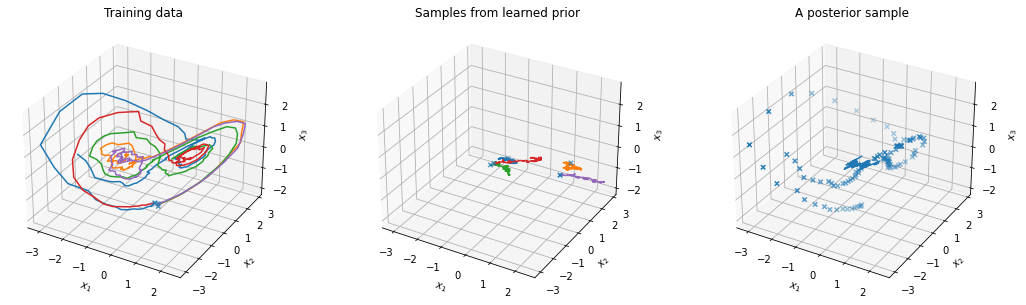

In [10]:
visualize(latent_sde, ts, xs, num_samples=5, key=vis_key)

Performing optimization

In [11]:
optim = optax.adam(learning_rate=lr)
opt_state = optim.init(eqx.filter(latent_sde, eqx.is_array))

iter = 0


@eqx.filter_jit
@eqx.filter_value_and_grad
def make_step(model):
    xs_pred, logpq = model(xs, ts, key=training_key)
    ll = normal_logprob(y=xs_pred, loc=xs, scale=scale)
    ll = jnp.mean(jnp.sum(ll, axis=(-2, -1)), axis=-1)
    kl = jnp.mean(logpq)
    loss = -ll + kl * min(1.0, (iter + 1) / kl_anneal_iters)
    return loss

Iteration 0 	 Loss: 3072694.500
Iteration 100 	 Loss: 424079.750
Iteration 200 	 Loss: 90313.594
Iteration 300 	 Loss: 48959.855
Iteration 400 	 Loss: 12521.310
Iteration 500 	 Loss: 8142.658
Plotting samples


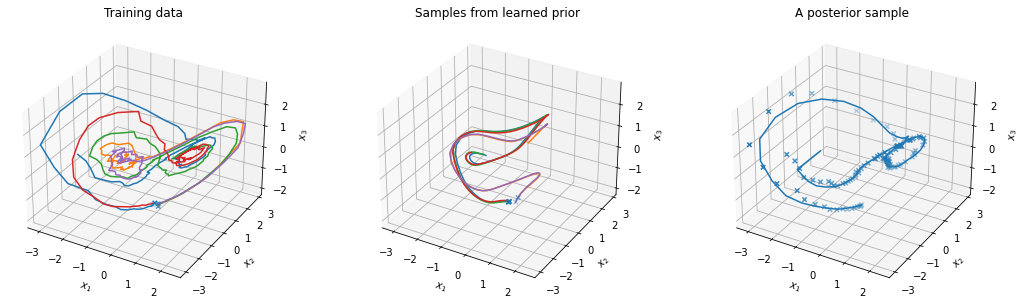

Iteration 600 	 Loss: 6879.693
Iteration 700 	 Loss: 4671.466
Iteration 800 	 Loss: 3947.010
Iteration 900 	 Loss: 3072.369
Iteration 1000 	 Loss: 2590.196
Plotting samples


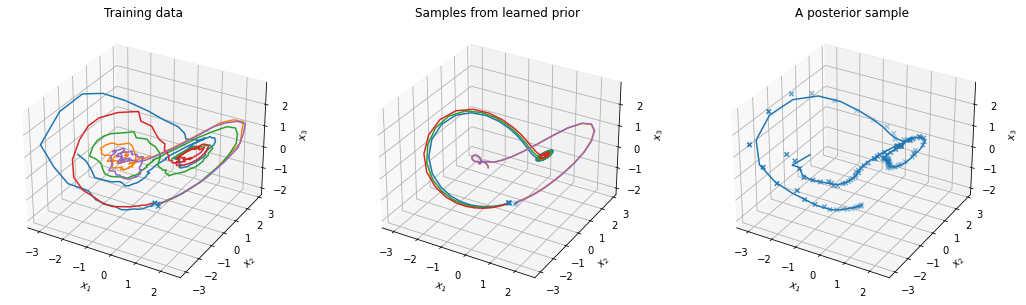

Iteration 1100 	 Loss: 1989.794
Iteration 1200 	 Loss: 1574.186
Iteration 1300 	 Loss: 1220.407
Iteration 1400 	 Loss: 751.642
Iteration 1500 	 Loss: 498.958
Plotting samples


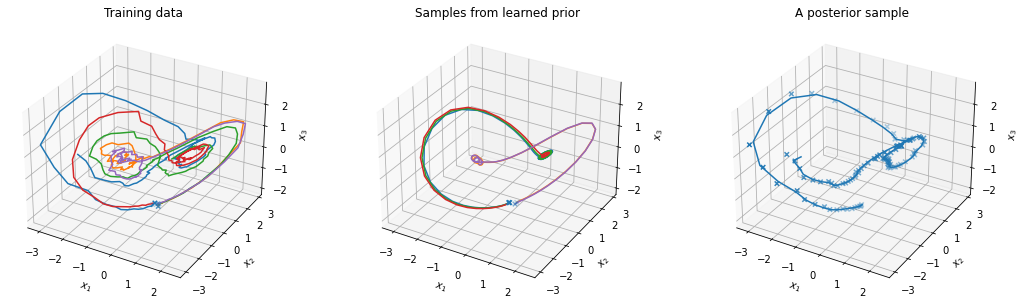

Iteration 1600 	 Loss: 425.140
Iteration 1700 	 Loss: 108.216
Iteration 1800 	 Loss: -200.149
Iteration 1900 	 Loss: -291.092
Iteration 2000 	 Loss: -389.237
Plotting samples


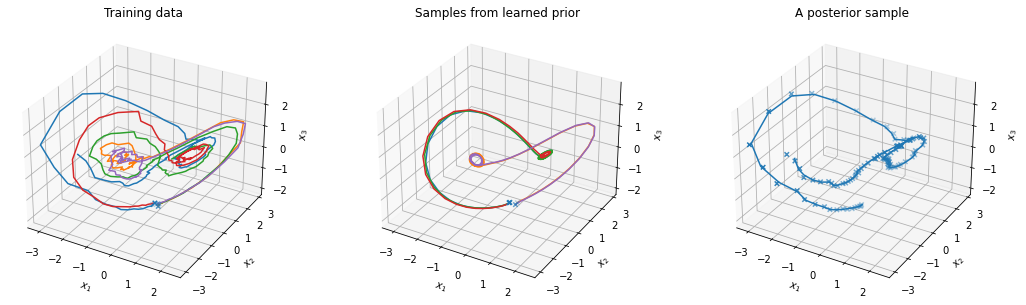

Iteration 2100 	 Loss: -434.973
Iteration 2200 	 Loss: -464.911
Iteration 2300 	 Loss: -295.922
Iteration 2400 	 Loss: -571.610
Iteration 2500 	 Loss: -545.513
Plotting samples


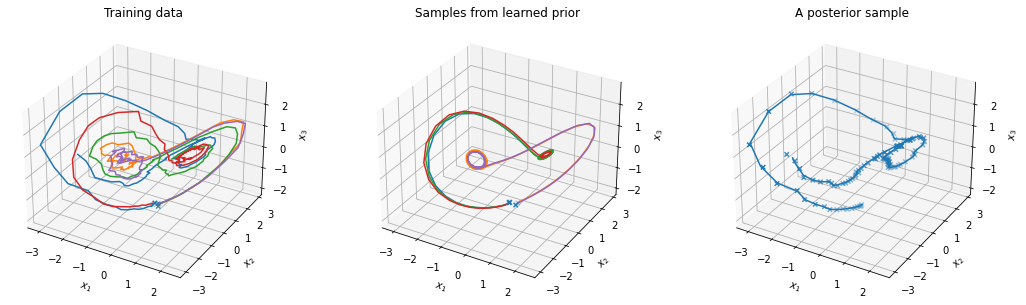

Iteration 2600 	 Loss: -614.248
Iteration 2700 	 Loss: -633.410
Iteration 2800 	 Loss: -643.400
Iteration 2900 	 Loss: -640.225
Iteration 3000 	 Loss: -677.333
Plotting samples


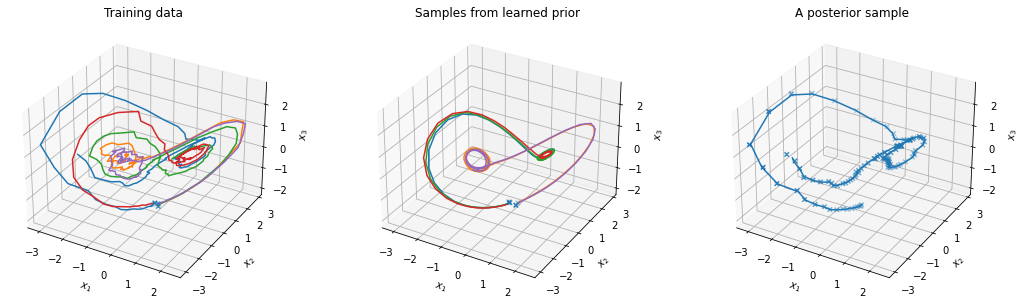

Iteration 3100 	 Loss: -662.211
Iteration 3200 	 Loss: -695.894
Iteration 3300 	 Loss: -705.672
Iteration 3400 	 Loss: -656.925
Iteration 3500 	 Loss: -658.869
Plotting samples


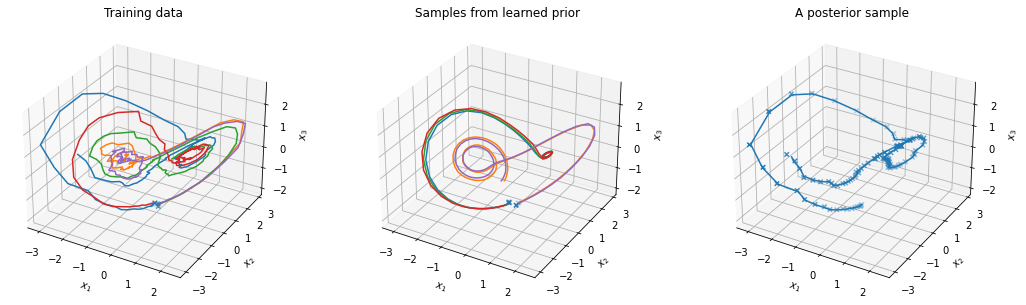

Iteration 3600 	 Loss: -739.727
Iteration 3700 	 Loss: -716.417
Iteration 3800 	 Loss: -750.179
Iteration 3900 	 Loss: -693.575
Iteration 4000 	 Loss: -695.594
Plotting samples


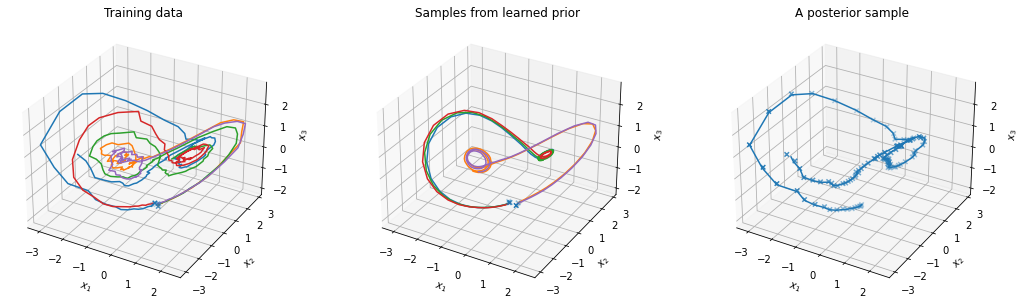

Iteration 4100 	 Loss: -628.097
Iteration 4200 	 Loss: -705.559
Iteration 4300 	 Loss: -755.328
Iteration 4400 	 Loss: -769.094
Iteration 4500 	 Loss: -770.626
Plotting samples


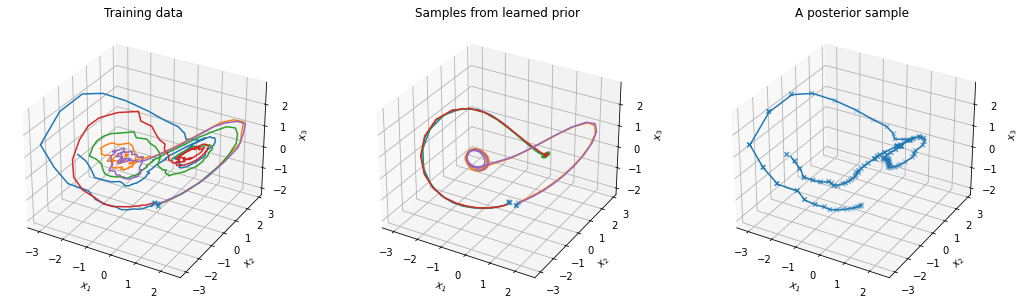

Iteration 4600 	 Loss: -778.362
Iteration 4700 	 Loss: -746.830
Iteration 4800 	 Loss: -250.368
Iteration 4900 	 Loss: -671.299


In [12]:
while iter < train_iters:
    # optimizing
    _, training_key = jrandom.split(training_key)
    loss, grads = make_step(latent_sde)
    loss = loss.item()
    updates, opt_state = optim.update(grads, opt_state)
    latent_sde = eqx.apply_updates(latent_sde, updates)
    if iter % pause_freq == 0:
        print(f"Iteration {iter} \t Loss: {loss:.3f}")
    if iter % plot_freq == 0 and iter > 1:
        print("Plotting samples")
        visualize(latent_sde, ts, xs, key=vis_key)
        plt.show()
    iter += 1

Visualize after training

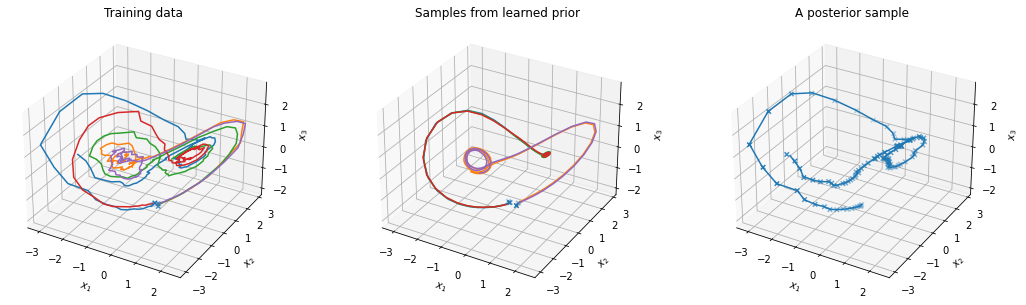

In [13]:
visualize(latent_sde, ts, xs, key=vis_key)